In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
import numpy as np

# Load the dataset
file_path = r'D:\python\Data Science\Python\E-Commerce Sales Analysis\data\datasets\International sale Report.csv'
df = pd.read_csv(file_path)

# Convert 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df.dropna(subset=['DATE'], inplace=True)  # Drop rows where date conversion failed

# Check column names to ensure they match our analysis needs
print("Columns in dataset:", df.columns)

Columns in dataset: Index(['index', 'DATE', 'Months', 'CUSTOMER', 'Style', 'SKU', 'Size', 'PCS',
       'RATE', 'GROSS AMT'],
      dtype='object')


C:\Users\dell\AppData\Local\Temp\ipykernel_7300\2552810452.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')


C:\Users\dell\AppData\Local\Temp\ipykernel_7300\1400160121.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PCS'].fillna(0, inplace=True)  # or you can use df.dropna(subset=['PCS'], inplace=True)


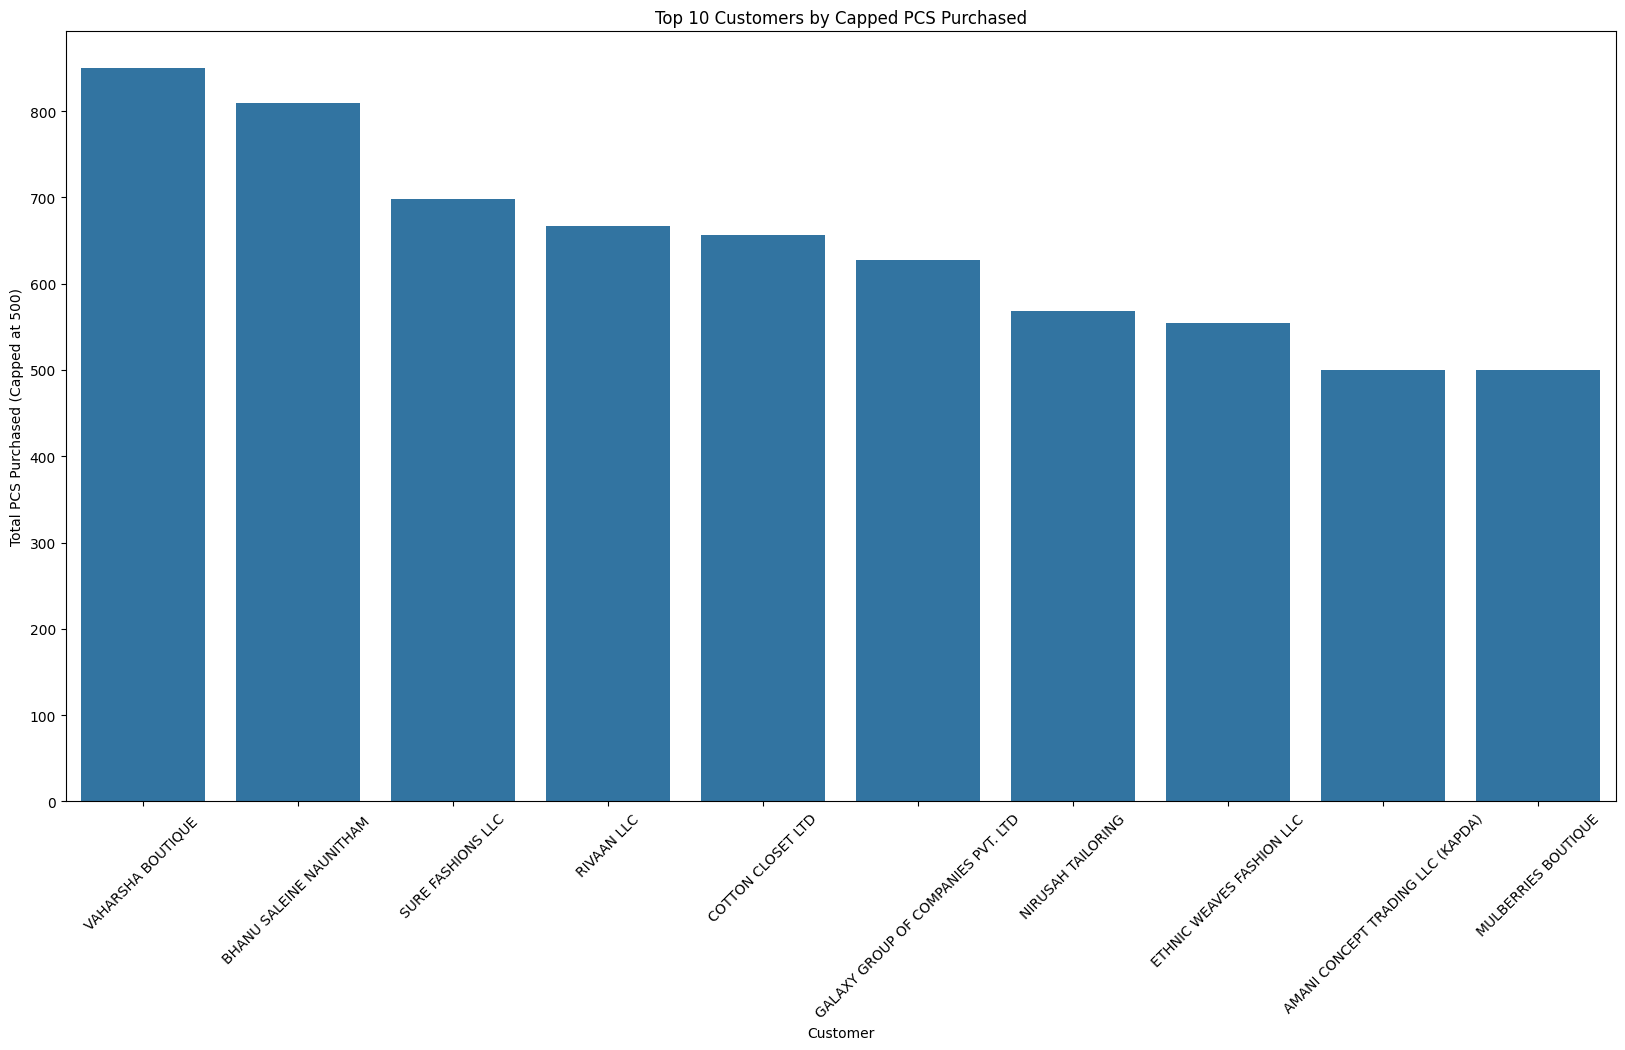

In [21]:
# 1. Identify frequent buyers based on quantity purchased
df['PCS'] = pd.to_numeric(df['PCS'], errors='coerce')
df['PCS'].fillna(0, inplace=True)  

customer_sales = df.groupby('CUSTOMER')['PCS'].sum().reset_index()

customer_sales['PCS_Capped'] = np.where(customer_sales['PCS'] > 1000, 500, customer_sales['PCS'])

#Sort by capped PCS values and plot top 10 customers
customer_sales = customer_sales.sort_values(by='PCS_Capped', ascending=False)

#  Plot the top 10 customers by capped PCS purchased
plt.figure(figsize=(20, 10))
sns.barplot(data=customer_sales.head(10), x='CUSTOMER', y='PCS_Capped')
plt.title('Top 10 Customers by Capped PCS Purchased')
plt.xlabel('Customer')
plt.ylabel('Total PCS Purchased (Capped at 500)')
plt.xticks(rotation=45)
plt.show()

In [30]:
df['DATE'] = pd.to_datetime(df['DATE'])

# Step 1: Calculate Recency, Frequency, and Monetary
snapshot_date = df['DATE'].max() + pd.Timedelta(days=1)  # For calculating recency

# Group by CustomerID to calculate RFM metrics
rfm = df.groupby('index').agg({
    'DATE': lambda x: (snapshot_date - x.max()).days,  # Recency
    'index': 'count',  # Frequency
    'RATE': 'sum'  # Monetary
}).rename(columns={'DATE': 'Recency', 'index': 'Frequency', 'RATE': 'Monetary'})

# Reset index to make CustomerID a column
rfm.reset_index(inplace=True)

# Show the calculated RFM DataFrame
print(rfm.head())



   index  Recency  Frequency Monetary
0      0      341          1   616.56
1      1      341          1   616.56
2      2      341          1   616.56
3      3      341          1   616.56
4      4      341          1   616.56


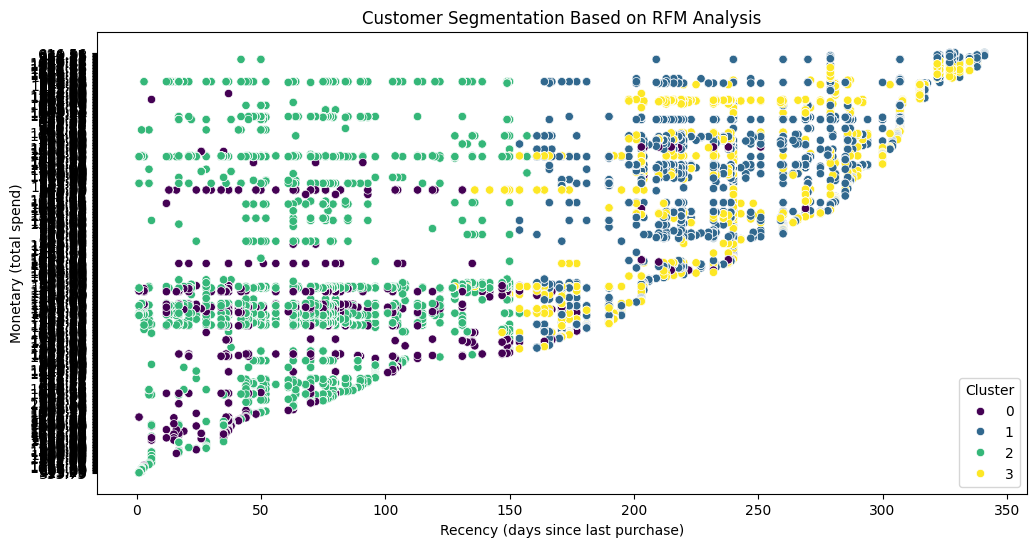

In [31]:
# Proceed with scaling and clustering as discussed earlier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize RFM values before clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Use KMeans to segment customers
kmeans = KMeans(n_clusters=4, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Plot clusters to see segmentation
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation Based on RFM Analysis')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spend)')
plt.legend(title='Cluster')
plt.show()

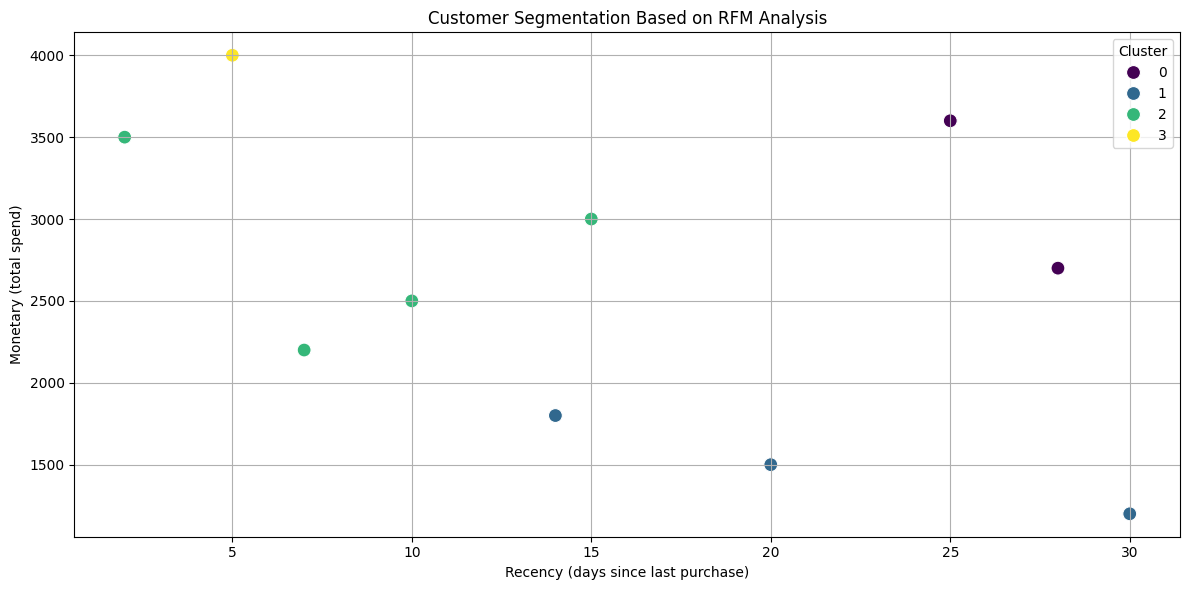


Cluster Centers:
     Recency  Frequency  Monetary  Cluster
0  26.500000      14.00    3150.0        0
1  21.333333      13.00    1500.0        1
2   8.500000      19.75    2800.0        2
3   5.000000      30.00    4000.0        3


In [35]:
data = {
    'CUSTOMER': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'Recency': [30, 15, 20, 5, 10, 25, 7, 14, 28, 2],  # Days since last purchase
    'Frequency': [10, 20, 15, 30, 25, 18, 22, 14, 10, 12],  # Number of purchases
    'Monetary': [1200, 3000, 1500, 4000, 2500, 3600, 2200, 1800, 2700, 3500]  # Total spend
}
rfm = pd.DataFrame(data)

# Step 1: Standardize RFM values before clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Step 2: Use KMeans to segment customers
n_clusters = 4  # You can adjust this based on the Elbow method or domain knowledge
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 3: Plot clusters to see segmentation
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation Based on RFM Analysis')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spend)')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

# Optional: Display cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Recency', 'Frequency', 'Monetary'])
cluster_centers_df['Cluster'] = range(n_clusters)
print("\nCluster Centers:")
print(cluster_centers_df)

In [36]:
# 5. Retention Rate Analysis (optional if data allows)
# Calculate retention rates by seeing the frequency of repeat purchases per customer
repeat_customers = rfm[rfm['Frequency'] > 1].shape[0]
total_customers = rfm.shape[0]
retention_rate = repeat_customers / total_customers

print(f"\nCustomer Retention Rate: {retention_rate:.2%}")


Customer Retention Rate: 100.00%
